# WSI - Zadanie 3 <br/>
### 20.11.2023 <br/>
Wojciech Pobocha
318399


In [331]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Klasa reprezentująca konkretny stan gry, posiada informacje jakie są potrzebne do oceny pozycji
Dla tej konkretnej gry z żetonami ma atrybuty:
- `_tokens` - ilość pozostałych żetonów,
- `_maximizingPlayer` - który gracz ma aktualnie ruch 

In [332]:
class TokenGameState:
    def __init__(self, tokens, maximizingPlayer):
        self._tokens = tokens
        self._maximizingPlayer = maximizingPlayer

    def getTokens(self):
        return self._tokens
    
    def getMaximizingPlayer(self):
        return self._maximizingPlayer

# Klasy, reprezentujące funkcje heurystyczne, oceniają dany stan gry
Muszą posiadać implementacje metody evaluate(state), która zwraca wartość dla określonego stanu.
## Implementacje:
- `TokenGameStateRandomEvaluator` - zwraca losowe wartości, potrafi tylko ocenić kto wygrał
- `TokenGameStateEvaluator` - potrafi trafnie ocenić, który gracz wygra - stworzona na podstawie gier i zauważenia wzoru w jaki przebiega rozgrywka

In [333]:
class TokenGameStateRandomEvaluator:
    def evaluate(self,state):
        if state.getTokens() == 1:
            if state.getMaximizingPlayer():
                return -1
            else:
                return 1
        return random.choice([-2, -1, 1, 2])

In [334]:
class TokenGameStateEvaluator:
    def __init__(self,k):
        self._k = k

    def getK(self):
        return self._k

    def isWinning(self, tokens):
        if (tokens-1)%(self.getK()+1)==0:
            return False
        else:
            return True
        


    def evaluate(self,state):
        if self.isWinning(state.getTokens()):
            if state.getMaximizingPlayer():
                return 1
            else:
                return -1
        else:
            if state.getMaximizingPlayer():
                return -1
            else:
                return 1

# Klasa odpowiedzialna za obsługę rozgrywki
Jej implementacja musi posiadać metody evaluate(state), isEndState(state), getOffsprings(state,maximizingPlayer).
Ta konkretna ma również atrybut _evaluator, która przyjmuje `TokenGameStateEvaluator` lub `TokenGameStateRandomEvaluator` by móc korzystać z tej klasy, dla różnych funkcji heurystycznych.

In [335]:
class TokenGameHandler:

    def __init__(self,k, evaluator):
        self._k = k
        self._evaluator = evaluator

    def getK(self):
        return self._k
    
    def getEvaluator(self):
        return self._evaluator

    def getOffsprings(self, state, maximizingPlayer):
        offsprings = []
        for i in range(1,self.getK()+1):
            if state.getTokens()-i < 1:
                continue
            offsprings.append(TokenGameState(state.getTokens()-i, not maximizingPlayer))
        random.shuffle(offsprings)
        return offsprings

    def evaluate(self, state):
        return self.getEvaluator().evaluate(state)

    def isEndState(self,state):
        return state.getTokens() ==1



# Sens powyższych klas
Powyższe klasy powstały, by algorytm minimax mógł mieć zastosowanie ogólne. W celu przetestowania algorytmu dla innej gry należy zaimplementować po jednej klasie z każdego rodzaju i połączyć ze sobą.

# Opis Algorytmu
1. Sprawdzenie czy podany stan gry nie jest końcowym, ani czy aktualna głębokość przeszukiwania nie jest równa 0,
2. Na podstawie parametru `maximizingPlayer` wyznaczona jest dalsza ścieżka algorytmu:
    -  True - ruch ma gracz maksymalizujący:
        1. Rozpoczyna od inicjalizacji najmniejszej możliwej wartości jako maxValue, aby w pierwszej pętli została ona bezwzględnie zaktualizowana,
        2. `gameHandler` dostarcza dozwoloną listę potomków, które zostały utworzone na podstawie aktualnego stanu. 
        3. Dla każdego potomka następuje rekurencyjne wywołanie algorytmu minimax z `depth` mniejszym o 1, aby sprawdzić jaki jest wynik zwracany z danej gałęzi poddrzewa, tym razem dla przeciwnego gracza, ponieważ ruchy wykonywane są na zmianę.
        4. Aktualizacja największej znalezionej wartości dla badanego stanu, a także alpha, która jest wartością zachowywaną dla całego wywołania algorytmu. Pod koniec sprawdzany jest warunek czy beta <= alpha, ponieważ gdy to nie jest prawdą dalsze przeszukiwanie tego drzewa ma sens. 
        5. Ostatecznie zwracana jest maksymalna wartość dla wszystkich z potomków danego stanu.
    - False - ruch ma gracz minimalizujący, wszystko analogicznie do gracza maksymalizującego z tą różnicą, że celem jest minimalizacja wartości zwracanej, dlatego zamiast maxValue jest minValue, beta, zamiast alpha i funkcje max zostały zastąpione min, warunek przerwania dalszego przeszukiwania ten sam.


### Parametry algorytmu
- `state` - stan gry, specyficzny dla konkretnej gry,
- `depth` - głębokość przeszukiwania,
- `alpha` - znaleziona wartość funkcji celu,
- `beta` - minimalna znaleziona wartość funkcji celu
- `maximizingPlayer` - wartość bool, True oznacza, że ruch ma gracz maksymalizujący (rozpoczynający rozgrywkę), False minimalizujący (drugi),
- `gameHandler` - klasa odpowiadająca za obsługę rozgrywki, robi to w sposób charakterystyczny dla konkretnej gry, lecz musi posiadać metody isEndState(state), evaluate(state), getOffsprings(state, maximizingPlayer)
    

In [336]:
def minimaxAlfaBeta2(state, depth, alpha, beta, maximizingPlayer, gameHandler):
    if depth == 0 or gameHandler.isEndState(state):
        return gameHandler.evaluate(state)
    if maximizingPlayer:
        maxValue = -np.inf
        for offspring in gameHandler.getOffsprings(state, maximizingPlayer):
            value = minimaxAlfaBeta2(offspring,depth-1,alpha,beta,False,gameHandler)
            maxValue = max(maxValue,value)
            alpha = max(alpha,value)
            if beta <= alpha:
                break
        return maxValue
    else:
        minValue = np.inf
        for offspring in gameHandler.getOffsprings(state, maximizingPlayer):
            value = minimaxAlfaBeta2(offspring,depth-1,alpha,beta,True,gameHandler)
            minValue = min(minValue,value)
            beta = min(beta,value)
            if beta <=alpha:
                break
        return minValue

In [ ]:
def launchMinimax(tokens,k,depth,randomEvaluator=False):
    
    state = TokenGameState(tokens, True)
    if randomEvaluator:
        tokenGameStateEvaluator = TokenGameStateRandomEvaluator()
    else:    
        tokenGameStateEvaluator = TokenGameStateEvaluator(k)
    tokenGameHandler = TokenGameHandler(k,tokenGameStateEvaluator)
    return minimaxAlfaBeta2(state,depth,-10,10,True, tokenGameHandler)

In [ ]:
def randomLaunchMinimax(minTokens,maxTokens,minK,maxK,depth,randomEvaluator=False):
    tokens = random.randint(minTokens,maxTokens)
    k = random.randint(minK,maxK)
    return launchMinimax(tokens,k,depth,randomEvaluator)

In [ ]:
def drawPlot(results,title):
    plt.bar(results.keys(), results.values())
    plt.xlabel('Who won')
    plt.ylabel('% of games')
    plt.title(title)
    plt.show()

In [ ]:
def getPercentageResults(unique_values, frequencies):
    results = {"MAX":0, "MIN":0}
    for i in range(len(unique_values)):
        if unique_values[i]>0:
            results["MAX"] += 100 * frequencies[i] / sum(frequencies)
        elif unique_values[i]<0:
            results["MIN"] += 100 * frequencies[i] / sum(frequencies)
    return results

In [ ]:

def summaryResultsMinimax(minTokens,maxTokens,minK,maxK,depth,matches,randomEvaluator=False):
    rawResults = []
    for _ in range(matches):
        result = randomLaunchMinimax(minTokens,maxTokens,minK,maxK,depth,randomEvaluator)
        rawResults.append(result)
    
    unique_values, frequencies = np.unique(rawResults, return_counts=True)
    return unique_values, frequencies


In [ ]:
def runDepthExperiment(minTokens,maxTokens,minK,maxK,matches,depths,randomEvaluator=False):
    combinedValues = []
    combinedFrequencies = []
    for depth in range(0,depths):
        unique_values, frequencies = summaryResultsMinimax(minTokens,maxTokens,minK,maxK,depth,matches,randomEvaluator)
        results = getPercentageResults(unique_values, frequencies)
        title = f'Depth: {depth}'
        drawPlot(results, title)
        combinedValues.append(unique_values)
        combinedFrequencies.append(frequencies)
    return combinedValues, combinedFrequencies

In [ ]:
def aggregateResults(combinedValues, combinedFrequencies):
    aggregatedValues = []
    aggregatedFrequencies = []
    for i in range(len(combinedValues)):
        aggregatedValues.extend(combinedValues[i])
        aggregatedFrequencies.extend(combinedFrequencies[i])
    return aggregatedValues, aggregatedFrequencies

# Losowa funkcja heurystyczna K: 3-3,Liczba tokenów: 8-20, Liczba meczy: 1000

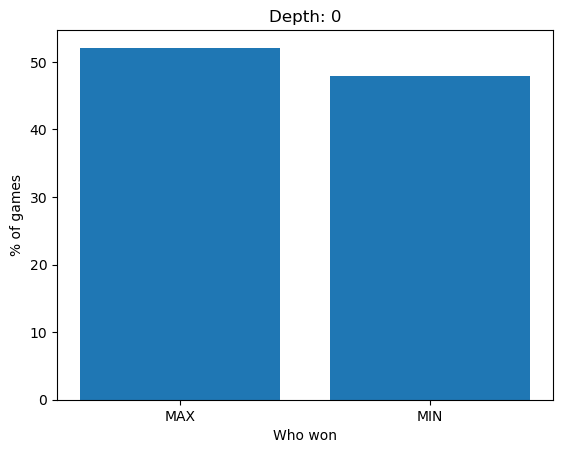

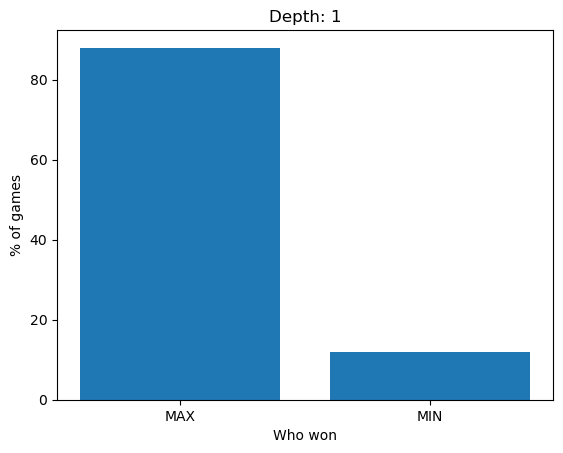

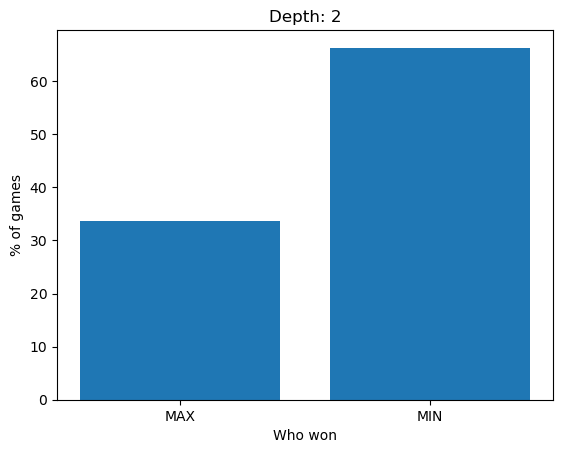

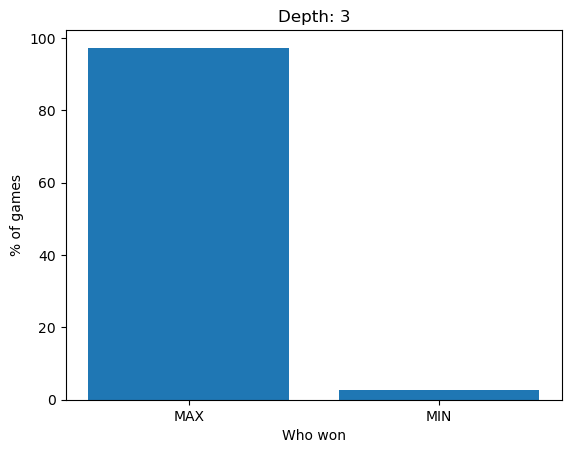

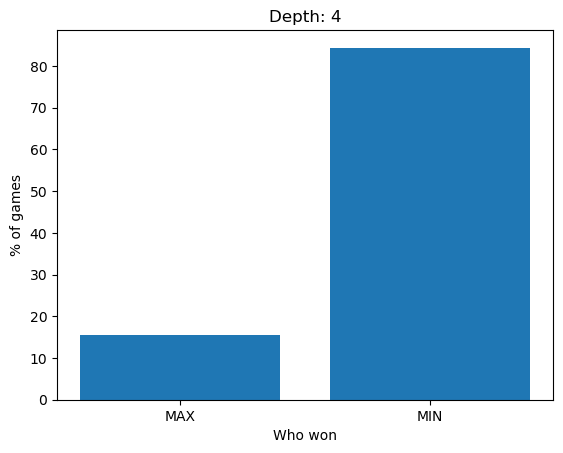

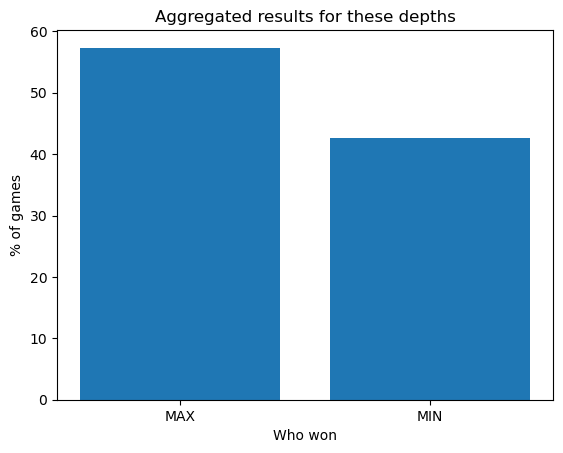

In [ ]:
minTokens = 8
maxTokens = 20
minK = 3
maxK = 3
matches = 1000
depths = 5
randomEvaluator = True
combinedValues,combinedFrequencies = runDepthExperiment(minTokens,maxTokens,minK,maxK,matches,depths,randomEvaluator)
aggregatedValues, aggregatedFrequencies = aggregateResults(combinedValues, combinedFrequencies)
drawPlot(getPercentageResults(aggregatedValues, aggregatedFrequencies), 'Aggregated results for these depths')

# Komentarz do wyników dla losowej funkcji heurystycznej

Z powyższych eksperymentów wynika, że dla losowej funkcji heurystycznej, która potrafi ocenić kto wygra wyłącznie, gdy ocenia stan terminalny, głębokość przeszukiwania algorytmu posiada kluczowe znaczenie. Oprócz tego, widać również, że dla głębokości=0, obaj gracze wygrywają w przybliżeniu taką samą liczbę gier, co jest logiczne, ponieważ wykonują losowe ruchy, a dopiero w stanie ostatecznym oceniają jaki jest wynik. Poszczególne wyniki sprawiają wrażenie, jakby określone głębokości faworyzowały określonych graczy, prawdopodobnie jest to wynik tego, że gdy tokenów jest 8-20, a K = 3, to średnio na takiej głębokości algorytm zauważa zwycięską ścieżkę. Podsumowując nieznacznie częściej wygrywa gracz max, dlatego że zaczyna, dla tej funkcji heurystycznej nie jest to jednak tak duża różnica.

# Przygotowana funkcja heurystyczna K: 3-3,Tokeny: 8-20, Liczba meczy: 1000

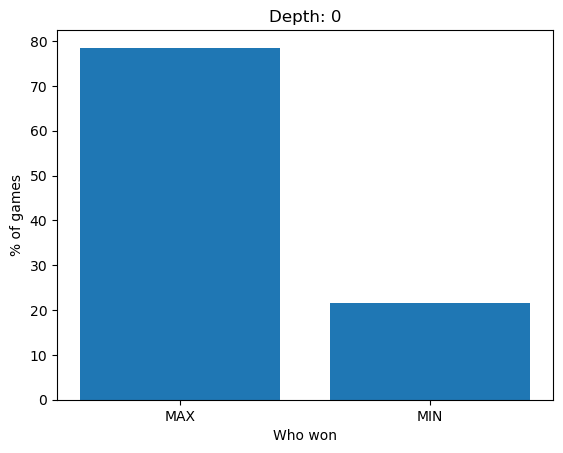

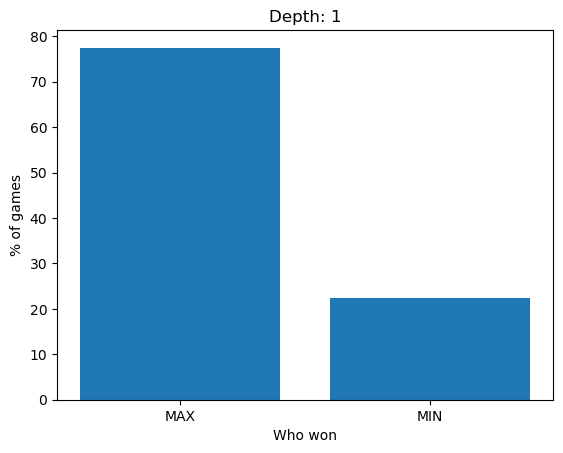

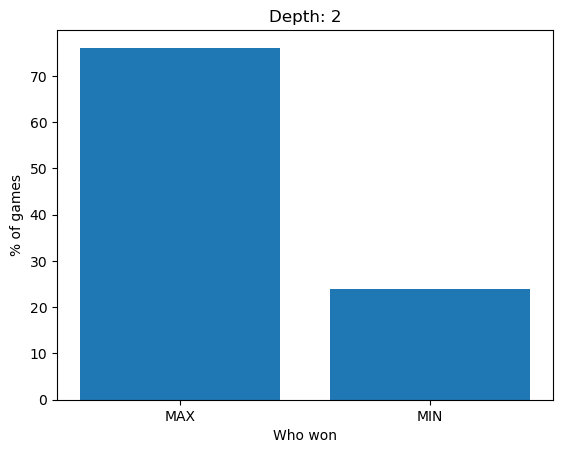

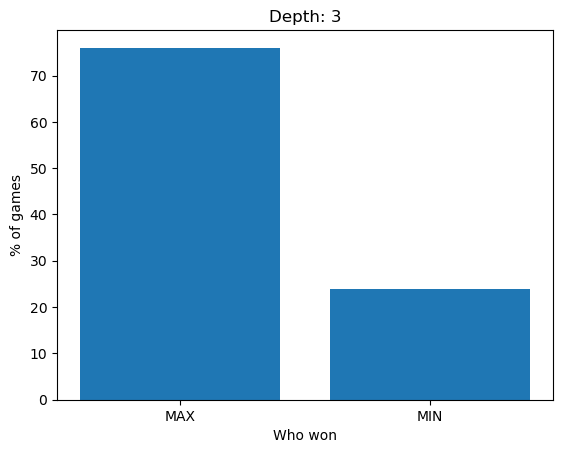

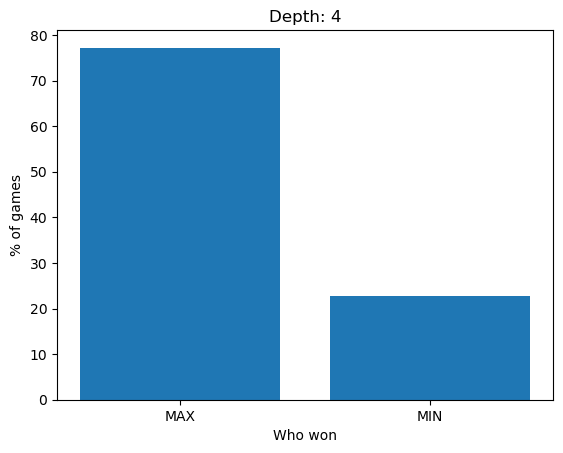

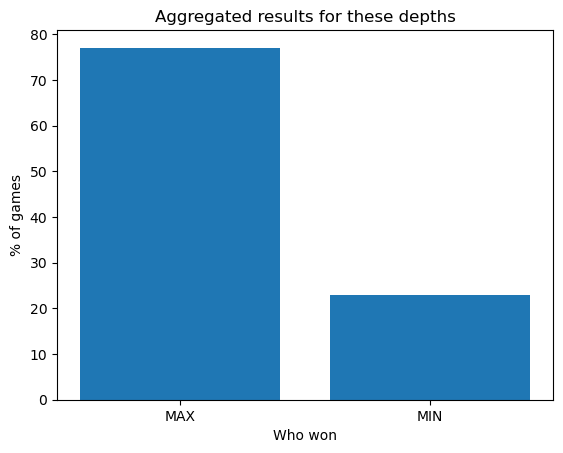

In [ ]:
minTokens = 8
maxTokens = 20
minK = 3
maxK = 3
matches = 1000
depths = 5
randomEvaluator = False
combinedValues,combinedFrequencies = runDepthExperiment(minTokens,maxTokens,minK,maxK,matches,depths,randomEvaluator)
aggregatedValues, aggregatedFrequencies = aggregateResults(combinedValues, combinedFrequencies)
drawPlot(getPercentageResults(aggregatedValues, aggregatedFrequencies), 'Aggregated results for these depths')

# Komentarz do wyników dla przygotowanej funkcji heurystycznej
Dla tej funkcji heurystycznej, widać że gracz max wygrywa w znacznej ilości przypadków, a także że głębokość przeszukiwania nie ma kompletnie żadnego znaczenia dla tej funkcji, ponieważ potrafi ona ocenić jednoznacznie na podstawie ilości pozostałych tokenów i liczby K, który gracz wygra. 

# Podsumowanie i ocena algorytmu
Na podstawie powyższych eksperymentów i porównania działania dwóch funkcji oceniających, mogę stwierdzić, że dobrze przygotowana funkcja heurystyczna odgrywa kluczową rolę w jakości działania algorytmu. Funkcja, która działa losowo przynosi losowe efekty, a jedyna rzecz, która może jej pomóc to duża głębokość przeszukiwania, która jest w stanie odnaleźć stan terminalny gry przynoszący pozytywny dla konkretnego gracza efekt. Przy nieskończonej głębokości przeszukiwania algorytm byłby w stanie przeszukać wszystkie stany i podać optymalny wynik, jednak nie jest to niestety możliwe, ze względu na wzrost liczby potrzebnych obliczeń do sprawdzenia całego drzewa. Dla przygotowanej przeze mnie funkcji heurystycznej głębokość przeszukiwania nie gra roli, jednak jest to efekt znalezienia optymalnej funkcji dla tej gry, nie dla wszystkich gier jest to możliwe lub po prostu może okazać się zbyt złożone.